In [256]:
import copy
from ts_utils import *

In [257]:
# online data load
# data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
# data = pd.read_csv(data_location + "energy/SF_hospital_load.csv")
# data.head(3)

In [258]:
# local data load
data = pd.read_csv("data/SF_hospital_load.csv")
data.head(3)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338


### Preparation

In [259]:
data = data.rename(columns={'ds':'datetime', 'y':'value'})
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
print(data)

                          value
datetime                       
2015-01-01 01:00:00  778.007969
2015-01-01 02:00:00  776.241750
2015-01-01 03:00:00  779.357338
2015-01-01 04:00:00  778.737196
2015-01-01 05:00:00  787.835835
...                         ...
2015-12-31 20:00:00  845.563081
2015-12-31 21:00:00  827.530521
2015-12-31 22:00:00  829.256300
2015-12-31 23:00:00  813.937205
2016-01-01 00:00:00  815.588584

[8760 rows x 1 columns]


In [260]:
freq = get_frequency(data)
print(freq)

H


In [261]:
seasonal = is_seasonal(data)
print(seasonal)

True


In [262]:
seasonal_period = get_seasonal_period(data)
print(seasonal_period)

24


In [263]:
from statsforecast import models

In [264]:
test_horizon = seasonal_period
plot_horizon = test_horizon*10

train_data = data.iloc[:-test_horizon]
test_data = data.iloc[-test_horizon:]

In [265]:
def plot_prediction(prediction_index, prediction_values, model_name):
    plt.plot(data.iloc[-plot_horizon:].index, data['value'].iloc[-plot_horizon:], label='Actual')
    plt.plot(prediction_index, prediction_values, label=model_name)
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Base models

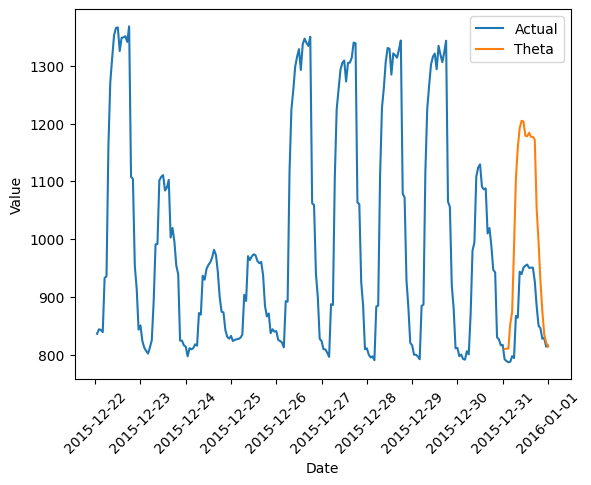

MODEL: Theta SMAPE: 18.85


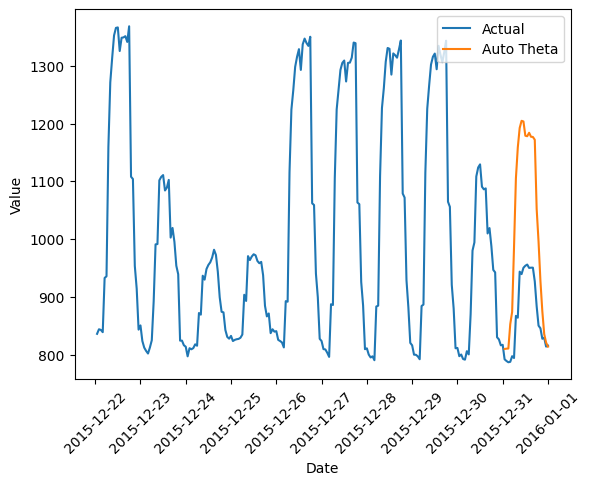

MODEL: Auto Theta SMAPE: 18.85


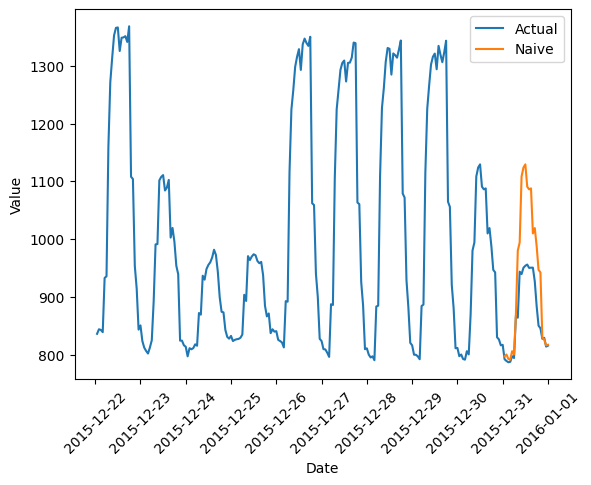

MODEL: Naive SMAPE: 13.38


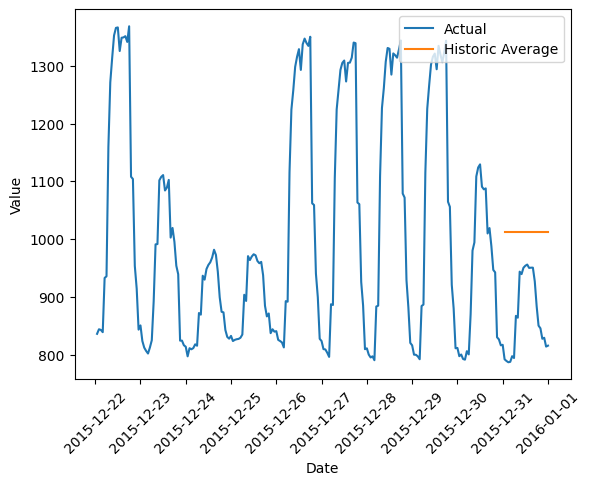

MODEL: Historic Average SMAPE: 15.50


In [266]:
# Base models creation and fitting
models = {  # TODO: Need to define standard model interface (input/output) to have a general meta-learner
    'Theta': models.Theta(season_length=seasonal_period),
    'Auto Theta': models.AutoTheta(season_length=seasonal_period),
    'Naive': models.SeasonalNaive(season_length=seasonal_period),
    'Historic Average': models.HistoricAverage(),
    #'Arima': models.AutoARIMA(season_length=period)  # TODO: Arima training does not stop
}

for model_name, model in models.items():
    model_copy = copy.deepcopy(model)  # Copying object to keep an untrained model for the meta-learner
    model_copy = model_copy.fit(y=train_data.value.to_numpy())
    prediction = model_copy.predict(h=test_horizon)['mean']
    plot_prediction(test_data.index, prediction, model_name)
    loss = calculate_smape(test_data, prediction)
    print(f'MODEL: {model_name} SMAPE: {loss:.2f}')

### Meta Learner

In [267]:
# Splitting data for base and meta models training
base_train_data_length = int(len(train_data)*0.5)
base_train_data = train_data[:-base_train_data_length]
meta_train_data = train_data[-base_train_data_length:]

In [268]:
# Base models creation and meta model weights calculation
losses = {}
predictions = {}

for model_name, model in models.items():
    model = model.fit(y=base_train_data.value.to_numpy())
    predictions[model_name] = model.predict(h=base_train_data_length)['mean']
    losses[model_name] = calculate_smape(meta_train_data, predictions[model_name])
    print(f'MODEL: {model_name} SMAPE: {losses[model_name]:.2f}')

weights = {model: 1/loss for model, loss in losses.items()}
total_weights = sum(weights.values())
print(f'Model weights\n{weights}')

MODEL: Theta SMAPE: 20.35
MODEL: Auto Theta SMAPE: 20.35
MODEL: Naive SMAPE: 18.70
MODEL: Historic Average SMAPE: 17.83
Model weights
{'Theta': 0.04913477577049232, 'Auto Theta': 0.04913654789547851, 'Naive': 0.05346582043420497, 'Historic Average': 0.056094192941757416}


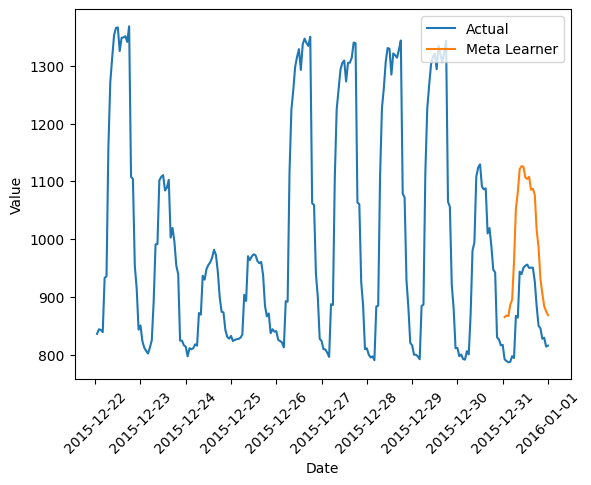

MODEL: Meta Learner
SMAPE: 15.35


In [269]:
# Calculate base models predictions and combines them with weights
meta_prediction = np.zeros(test_horizon)

for model_name, model in models.items():
    model_weight = weights[model_name] / total_weights
    meta_prediction += model.predict(h=test_horizon)['mean'] * model_weight

plot_prediction(test_data.index, meta_prediction, 'Meta Learner')
loss = calculate_smape(test_data, meta_prediction)
print(f'MODEL: Meta Learner\nSMAPE: {loss:.2f}')